In [3]:
import jax
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import random
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple, NamedTuple
import functools

### Parallelism in JAX
Parallelism in JAX is handled by another fundamental transform function: pmap

In [ ]:
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [ ]:
# Let's use a simple running example here
x = np.arange(5)  # signal
w = np.array([2., 3., 4.])  # window/kernel

def convolve(w, x):  # implementation of 1D convolution/correlation
    output = []

    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))

    return jnp.array(output)

result = convolve(w, x)
print(repr(result))


Array([11., 20., 29.], dtype=float32)


In [ ]:
n_devices = jax.local_device_count()
print(f'Number of available devices: {n_devices}')

# Let's now imagine we have a much heavier load (a batch of examples)
xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

print(xs.shape, ws.shape)

Number of available devices: 8
(8, 5) (8, 3)


In [ ]:
# First way to optimize this is to simply use vmap
vmap_result = jax.vmap(convolve)(ws, xs)
print(repr(vmap_result))

Array([[ 11.,  20.,  29.],
       [ 56.,  65.,  74.],
       [101., 110., 119.],
       [146., 155., 164.],
       [191., 200., 209.],
       [236., 245., 254.],
       [281., 290., 299.],
       [326., 335., 344.]], dtype=float32)


In [ ]:
#The amazing thing is if you just swap vmap for pmap you are now running on multiple
# devices.
pmap_result = jax.pmap(convolve)(ws, xs)
print(repr(pmap_result))  # ShardedDeviceArray!

Array([[ 11.,  20.,  29.],
       [ 56.,  65.,  74.],
       [101., 110., 119.],
       [146., 155., 164.],
       [191., 200., 209.],
       [236., 245., 254.],
       [281., 290., 299.],
       [326., 335., 344.]], dtype=float32)


In [ ]:
# No cross-device communication costs. Computations are done independently on each dev.
double_pmap_result = jax.pmap(convolve)(jax.pmap(convolve)(ws, xs), xs)
print(repr(double_pmap_result))

Array([[   78.,   138.,   198.],
       [ 1188.,  1383.,  1578.],
       [ 3648.,  3978.,  4308.],
       [ 7458.,  7923.,  8388.],
       [12618., 13218., 13818.],
       [19128., 19863., 20598.],
       [26988., 27858., 28728.],
       [36198., 37203., 38208.]], dtype=float32)


In [ ]:
# Same results but we don't have to manually broadcast w (recall: same as for vmap!)
pmap_smarter_result = jax.pmap(convolve, in_axes=(None, 0))(w, xs)
print(repr(pmap_smarter_result))

Array([[ 11.,  20.,  29.],
       [ 56.,  65.,  74.],
       [101., 110., 119.],
       [146., 155., 164.],
       [191., 200., 209.],
       [236., 245., 254.],
       [281., 290., 299.],
       [326., 335., 344.]], dtype=float32)


### Communication between devices

In [ ]:
# Same example as above but this time we communicate across devices
# in order to normalize the outputs
def normalized_convolution(w, x):
    output = []

    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))

    output = jnp.array(output)  # same result as before

    return output / jax.lax.psum(output, axis_name='batch_dim')  # this is where communication happens

res_pmap = jax.pmap(normalized_convolution, axis_name='batch_dim', in_axes=(None, 0))(w, xs)
res_vmap = jax.vmap(normalized_convolution, axis_name='batch_dim', in_axes=(None, 0))(w, xs)

print(repr(res_pmap))
print(repr(res_vmap))

print(f'Verify the output is normalized: {sum(res_pmap[:, 0])}')

Array([[0.00816024, 0.01408451, 0.019437  ],
       [0.04154303, 0.04577465, 0.04959785],
       [0.07492582, 0.07746479, 0.07975871],
       [0.10830861, 0.10915492, 0.10991956],
       [0.14169139, 0.14084506, 0.14008042],
       [0.17507419, 0.17253521, 0.17024128],
       [0.20845698, 0.20422535, 0.20040214],
       [0.24183977, 0.23591548, 0.23056298]], dtype=float32)
Array([[0.00816024, 0.01408451, 0.019437  ],
       [0.04154303, 0.04577465, 0.04959785],
       [0.07492582, 0.07746479, 0.07975871],
       [0.10830861, 0.10915492, 0.10991956],
       [0.14169139, 0.14084506, 0.14008042],
       [0.17507419, 0.17253521, 0.17024128],
       [0.20845698, 0.20422535, 0.20040214],
       [0.24183977, 0.23591548, 0.23056298]], dtype=float32)
Verify the output is normalized: 1.0


### Training a very simple model in parallel!

In [8]:
class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray


lr = 0.01


def init_model(rng):
    weights_key, bias_key = jax.random.split(rng)
    weight = jax.random.normal(weights_key, ())
    bias = jax.random.normal(bias_key, ())
    return Params(weight, bias)


def forward(params, xs):
    return params.weight * xs + params.bias


def loss_fn(params, xs, ys):
    pred = forward(params, xs)
    return jnp.mean((pred - ys) ** 2)  # MSE


@functools.partial(jax.pmap, axis_name='batch')
def update(params, xs, ys):

    # Compute the gradients on the given minibatch (individually on each device).
    loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

    # Combine the gradient across all devices (by taking their mean).
    grads = jax.lax.pmean(grads, axis_name='batch')

    # Also combine the loss. Unnecessary for the update, but useful for logging.
    loss = jax.lax.pmean(loss, axis_name='batch')

    # Each device performs its own SGD update, but since we start with the same params
    # and synchronise gradients, the params stay in sync on each device.
    new_params = jax.tree_map(
        lambda param, g: param - g * lr, params, grads)

    # If we were using Adam or another stateful optimizer,
    # we would also do something like:
    # updates, new_optimizer_state = optimizer(grads, optimizer_state)
    # and then use updates instead of grads to actually update the params.
    # (And we'd include the new_optimizer_state in the output, naturally.)

    return new_params, loss

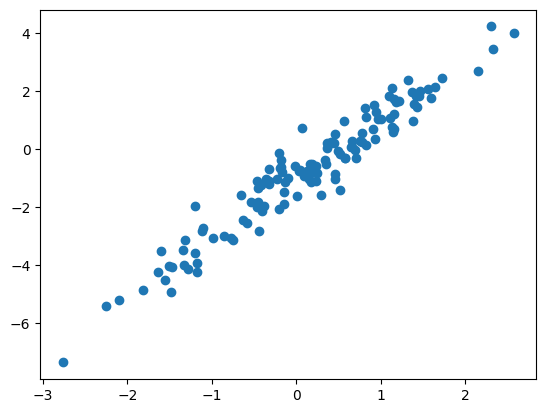

In [9]:
# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

plt.scatter(xs, ys)
plt.show()

In [10]:
# Initialise parameters and replicate across devices.
params = init_model(jax.random.PRNGKey(0))
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
print(replicated_params)

# Prepare the data
def reshape_for_pmap(data, n_devices):
    return data.reshape(n_devices, data.shape[0] // n_devices, *data.shape[1:])

x_parallel = reshape_for_pmap(xs, n_devices)
y_parallel = reshape_for_pmap(ys, n_devices)

print(x_parallel.shape, y_parallel.shape)

Params(weight=Array([1.0040118, 1.0040118, 1.0040118, 1.0040118, 1.0040118, 1.0040118,
       1.0040118, 1.0040118], dtype=float32), bias=Array([-2.4424531, -2.4424531, -2.4424531, -2.4424531, -2.4424531,
       -2.4424531, -2.4424531, -2.4424531], dtype=float32))
(8, 16, 1) (8, 16, 1)


In [13]:
def type_after_update(name, obj):
    print(f"after first `update()`, `{name}` is a {type(obj)}")

# Actual training loop
num_epochs = 500
for epoch in range(num_epochs):

    # This is where the params and data gets communicated to devices
    replicated_params, loss = update(replicated_params, x_parallel, y_parallel)

    # replicated_params and loss are now both ShardedDeviceArrays,
    # indicating that they're on the devices.
    # x/y_parallel remains a NumPy array on the host (simulating data streaming).
    if epoch == 0:
        type_after_update('replicated_params.weight', replicated_params.weight)
        type_after_update('loss', loss)
        type_after_update('x_parallel', x_parallel)

    if epoch % 100 == 0:
        print(loss.shape)
        print(f"Step {epoch:3d}, loss: {loss[0]:.3f}")

# Like the loss, the leaves of params have an extra leading dimension,
# so we take the params from the first device.
params = jax.device_get(jax.tree_map(lambda x: x[0], replicated_params))

after first `update()`, `replicated_params.weight` is a <class 'jaxlib.xla_extension.ArrayImpl'>
after first `update()`, `loss` is a <class 'jaxlib.xla_extension.ArrayImpl'>
after first `update()`, `x_parallel` is a <class 'numpy.ndarray'>
(8,)
Step   0, loss: 0.287
(8,)
Step 100, loss: 0.287
(8,)
Step 200, loss: 0.287
(8,)
Step 300, loss: 0.287
(8,)
Step 400, loss: 0.287


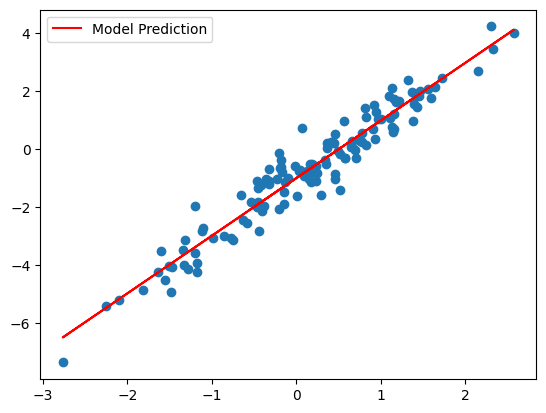

In [14]:
plt.scatter(xs, ys)
plt.plot(xs, forward(params, xs), c='red', label='Model Prediction')
plt.legend()
plt.show()
